In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
df_cherry = pd.read_csv('cherry.csv')

In [3]:
df_cherry = df_cherry.rename(columns={'yield': 'fruit_set'})

In [4]:
# Select only the numerical columns for correlation
numerical_df_cherry = df_cherry.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numerical_df_cherry.corr()

# Extract the correlations of 'fruit_set' with other columns
cherry_yield_corr = corr['fruit_set']

# Display the correlations
print('Fruit Set')
print(cherry_yield_corr)



Fruit Set
Unnamed: 0                     -0.446008
field_size                     -0.259352
fruit_set                       1.000000
observed_pollinator_richness    0.453992
abundance                      -0.019882
ab_honeybee                    -0.203876
ab_bombus                       0.305579
ab_wildbees                     0.197625
ab_syrphids                     0.339646
ab_humbleflies                       NaN
ab_other_flies                       NaN
ab_beetles                           NaN
ab_lepidoptera                       NaN
ab_nonbee_hymenoptera                NaN
ab_others                            NaN
total_sampled_area              0.294102
total_sampled_time             -0.416533
Name: fruit_set, dtype: float64


Linear regression: Predicting fruit set based on several features individually

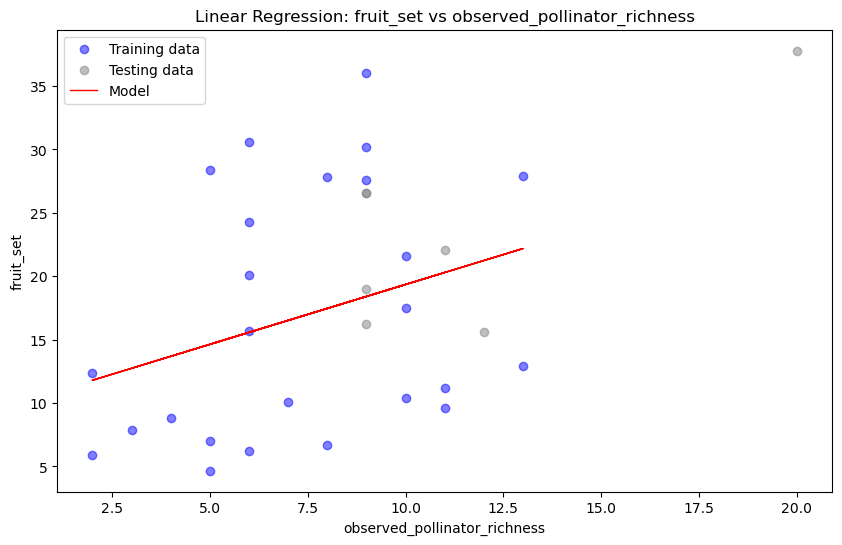

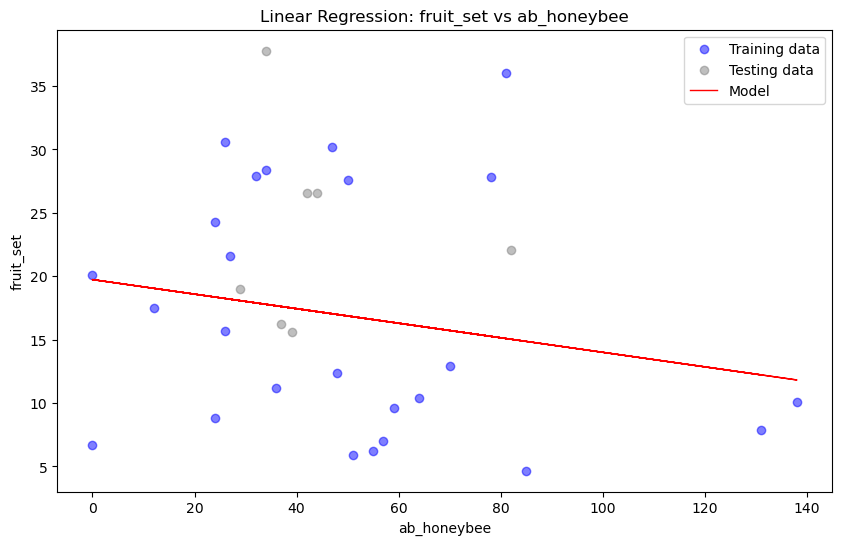

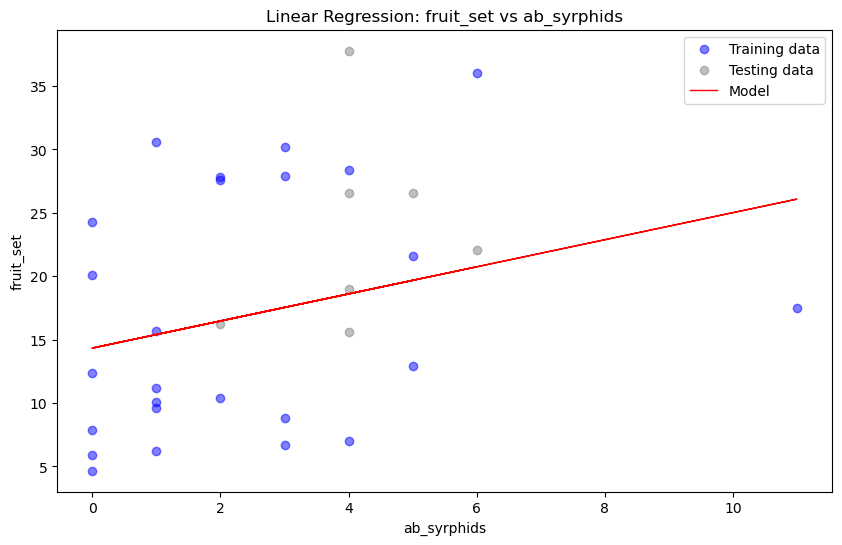

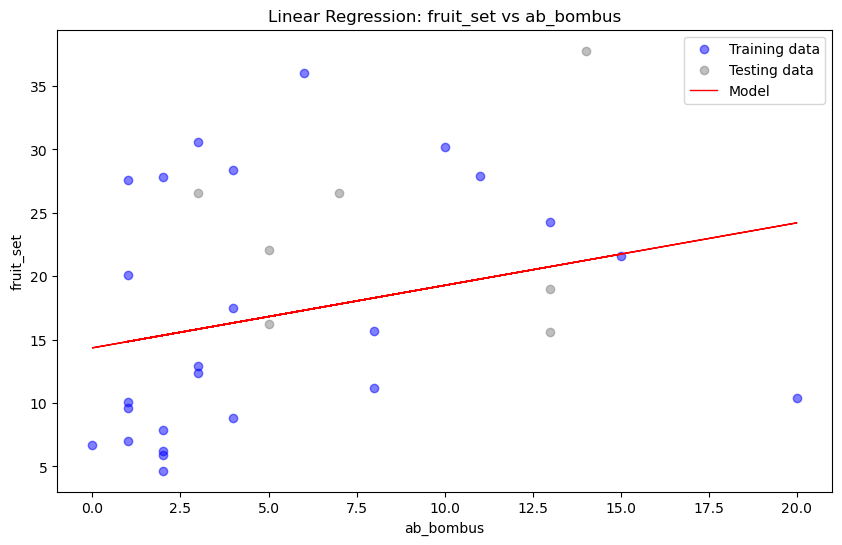

,Feature,Coefficient,Intercept,MAE,MSE,RMSE,R2
0,observed_pollinator_richness,0.945,9.90,5.09,36.56,6.05,0.29
1,ab_honeybee,-0.057,19.74,7.14,90.18,9.50,-0.74
2,ab_syrphids,1.068,14.34,5.59,70.20,8.38,-0.36
3,ab_bombus,0.493,14.35,7.00,75.06,8.66,-0.45


In [6]:
def test_features(df, features, target):
    """
    Test multiple features for linear regression models, visualize the regression for each feature
    with both training and testing data.
    
    Parameters:
    - df: DataFrame containing the dataset.
    - features: List of feature names to test.
    - target: Name of the target variable.
    
    Returns:
    - A DataFrame with the results of the analysis for each feature.
    """
    # Initialize an empty list to store results
    results = []
    
    for feature in features:
        # Prepare the data
        X = df[[feature]]  # Feature matrix
        y = df[target]  # Target variable
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
        
        # Create and train the linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Predict target values for both training and testing set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate evaluation metrics using test set
        mae = round(mean_absolute_error(y_test, y_pred_test), 2)
        mse = round(mean_squared_error(y_test, y_pred_test), 2)
        rmse = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
        R2 = round(r2_score(y_test, y_pred_test), 2)
        
        # Append the results
        results.append({
            'Feature': feature,
            'Coefficient': round(model.coef_[0], 3),
            'Intercept': round(model.intercept_, 2),
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': R2
        })
        
        # Visualization
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Training data')
        plt.scatter(X_test, y_test, color='gray', alpha=0.5, label='Testing data')
        plt.plot(X_train, y_pred_train, 'r-', linewidth=1, label='Model')
        plt.title(f'Linear Regression: {target} vs {feature}')
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.legend()
        plt.show()
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
features_to_test = ['observed_pollinator_richness', 'ab_honeybee', 'ab_syrphids', 'ab_bombus']
target_column = 'fruit_set'
results_df = test_features(df_cherry, features_to_test, target_column)

display(results_df)


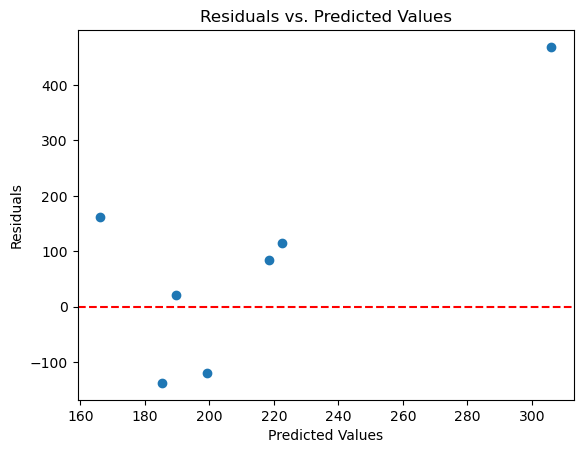

In [14]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting the residuals
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Adds a horizontal line at zero
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


In [27]:
# Assuming df_almond is your DataFrame and 'fruits_per_plant' is the column to clean

# Calculate Q1, Q3, and IQR
Q1 = df_almond['fruits_per_plant'].quantile(0.25)
Q3 = df_almond['fruits_per_plant'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for what is considered an acceptable range (no outliers)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_almond_cleaned = df_almond[(df_almond['fruits_per_plant'] >= lower_bound) & (df_almond['fruits_per_plant'] <= upper_bound)]

# Optionally, to see how many rows were removed
rows_removed = df_almond.shape[0] - df_almond_cleaned.shape[0]
print(f"Rows before cleaning: {df_almond.shape[0]}, rows after cleaning: {df_almond_cleaned.shape[0]}, rows removed: {rows_removed}")


Rows before cleaning: 34, rows after cleaning: 33, rows removed: 1


Multiple linear regression

In [7]:
# Prepare the data
features = ['observed_pollinator_richness','abundance', 'ab_honeybee', 'ab_bombus', 'ab_syrphids']
X = df_cherry[features]  # Feature matrix
y = df_cherry['fruit_set']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Predict 'yield2' values for the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
rmse = round(mean_squared_error(y_test, y_pred, squared=False),2)
R2 = round(r2_score(y_test, y_pred),2)

# Print the model coefficients and evaluation metrics
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared score:", R2)


Coefficients: [ 1.16626673 -0.02454096 -0.0401792   0.22999916 -0.05391864]
Intercept: 10.199550784188357
Mean Absolute Error: 8.52
Mean Squared Error: 111.45
Root Mean Squared Error: 10.56
R-squared score: -0.11


Random Forest

In [9]:
# Define your features and target variable
features = ['observed_pollinator_richness', 'abundance', 'ab_honeybee', 'ab_bombus', 'ab_wildbees']
X = df_cherry[features]
y = df_cherry['fruit_set']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 6.130314285714287
Mean Squared Error (MSE): 66.49005346000006
Root Mean Squared Error (RMSE): 8.154143330847212
R-squared (R2): 0.3404853847754893


Cross-validation on simple linear with feature honeybee abundance

In [38]:
X = df_almond[['ab_honeybee']].values  # Predictor
y = df_almond['fruits_per_plant'].values  # Target variable

# Initialize the linear regression model
model = LinearRegression()

# Define the K-Fold cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=2)  # 5 folds

# Calculate cross-validated MAE scores and convert to positive (as scores are negative)
mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
# Calculate cross-validated MSE scores and convert to positive
mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
# Calculate cross-validated R^2 scores
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Print the average scores
print(f"Average MAE across all folds: {round(np.mean(mae_scores),2)}")
print(f"Average MSE across all folds: {round(np.mean(mse_scores),2)}")
print(f"Average RMSE across all folds: {round(np.mean(np.sqrt(mse_scores)),2)}")  # RMSE is the square root of MSE
print(f"Average R-squared across all folds: {round(np.mean(r2_scores),2)}") 



Average MAE across all folds: 108.45
Average MSE across all folds: 21098.21
Average RMSE across all folds: 135.48
Average R-squared across all folds: 0.15


In [39]:
X = df_almond[['abundance']].values  # Predictor
y = df_almond['fruits_per_plant'].values  # Target variable

# Initialize the linear regression model
model = LinearRegression()

# Define the K-Fold cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=2)  # 5 folds

# Calculate cross-validated MAE scores and convert to positive (as scores are negative)
mae_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
# Calculate cross-validated MSE scores and convert to positive
mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
# Calculate cross-validated R^2 scores
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

# Print the average scores
print(f"Average MAE across all folds: {round(np.mean(mae_scores),2)}")
print(f"Average MSE across all folds: {round(np.mean(mse_scores),2)}")
print(f"Average RMSE across all folds: {round(np.mean(np.sqrt(mse_scores)),2)}")  # RMSE is the square root of MSE
print(f"Average R-squared across all folds: {round(np.mean(r2_scores),2)}") 



Average MAE across all folds: 113.78
Average MSE across all folds: 22166.27
Average RMSE across all folds: 138.01
Average R-squared across all folds: 0.14
